In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [2]:
parameters = {'kernel':['rbf'],
              'C':[0.5, 1, 5, 10, 50, 100, 500, 1000],
              'epsilon':[0.1,0.01,0.001]}

In [3]:
def GridSearch(rf, X_train, X_test, y_train, y_test, grid, verbose=False, skip=False):
    best_score = 0
    par = ParameterGrid(grid)
    ln = len(par)
    i = 0
    for g in par:
        if skip and i == 46:
            continue
        if(verbose):
            print(f"Probando: {g}, {i} de {ln}")
        i+=1
        rf.set_params(**g)
        startTime = time.time()
        rf.fit(X_train, np.ravel(y_train))
        elapsedTime = time.time() - startTime
        score = rf.score(X_test, y_test)
        if(verbose):
            print(f"Tiempo de entrenamiento: {elapsedTime} s, score: {score}")
        # save if best
        if score > best_score:
            best_score = score
            best_grid = g
    print(f"Best Score: {best_score}")
    print(f"Best Parameters: {best_grid}")
    return best_grid

In [4]:
Year_to_separate = 2000
df = pd.read_parquet("dataset.parquet")
Y = df[['Municipal', 'Year']]
X = df[[x for x in df.columns if x not in ['Country', 'COU', 'Municipal', 'Household', 'Recovered', 'Recicled', 'Compost', 'Disposal']]]
X_train = X[X.Year < Year_to_separate].copy()
X_test = X[X.Year >= Year_to_separate].copy()
Y_train = Y[X.Year < Year_to_separate].copy()
Y_test = Y[X.Year >= Year_to_separate].copy()
#X_train = pd.read_parquet("Xtime/X_train.parquet")
#X_test = pd.read_parquet("Xtime/X_test.parquet")
#Y_train = pd.read_parquet("Ytime/Y_train.parquet")
#Y_test = pd.read_parquet("Ytime/Y_test.parquet")
X_train.drop(columns={'Year'}, inplace=True)
X_test.drop(columns={'Year'}, inplace=True)
scalerX = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train))
X_test = pd.DataFrame(scalerX.transform(X_test))
scalerY = MinMaxScaler().fit(Y_train)
Y_train = pd.DataFrame(scalerY.transform(Y_train))
Y_test = pd.DataFrame(scalerY.transform(Y_test))
Y_train = Y_train[[Y_train.columns[0]]]
Y_test = Y_test[[Y_test.columns[0]]]

In [5]:
g = GridSearch(svm.SVR(), X_train, X_test, Y_train, Y_test, parameters, verbose=True)
clf1 = svm.SVR(**g).fit(X_train, np.ravel(Y_train))

Probando: {'C': 0.5, 'epsilon': 0.1, 'kernel': 'rbf'}, 0 de 24
Tiempo de entrenamiento: 0.008343935012817383 s, score: 0.5218088718583496
Probando: {'C': 0.5, 'epsilon': 0.01, 'kernel': 'rbf'}, 1 de 24
Tiempo de entrenamiento: 0.013231992721557617 s, score: 0.644915091917142
Probando: {'C': 0.5, 'epsilon': 0.001, 'kernel': 'rbf'}, 2 de 24
Tiempo de entrenamiento: 0.04322409629821777 s, score: 0.6454989320695825
Probando: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}, 3 de 24
Tiempo de entrenamiento: 0.008118629455566406 s, score: 0.5166643756757919
Probando: {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}, 4 de 24
Tiempo de entrenamiento: 0.02086639404296875 s, score: 0.651029589319906
Probando: {'C': 1, 'epsilon': 0.001, 'kernel': 'rbf'}, 5 de 24
Tiempo de entrenamiento: 0.03667449951171875 s, score: 0.6430216654400145
Probando: {'C': 5, 'epsilon': 0.1, 'kernel': 'rbf'}, 6 de 24
Tiempo de entrenamiento: 0.00632476806640625 s, score: 0.5541365400113343
Probando: {'C': 5, 'epsilon': 0.01, 'kerne

In [6]:
df.COU.unique()

array(['AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK', 'FIN', 'FRA', 'DEU',
       'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'JPN', 'KOR', 'LUX', 'MEX',
       'NLD', 'NZL', 'NOR', 'POL', 'PRT', 'SVK', 'ESP', 'SWE', 'CHE',
       'TUR', 'GBR', 'USA', 'BRA', 'CHL', 'CHN', 'EST', 'IDN', 'ISR',
       'RUS', 'SVN', 'COL', 'LVA', 'CRI', 'IND', 'LTU'], dtype=object)

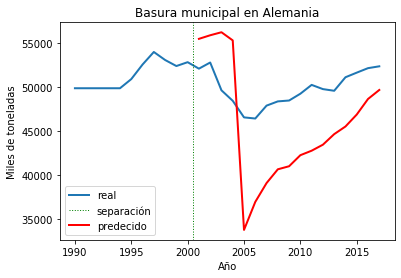

2.5288987816788406


In [7]:
country = 'DEU'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en Alemania")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
deu2000 = predictions

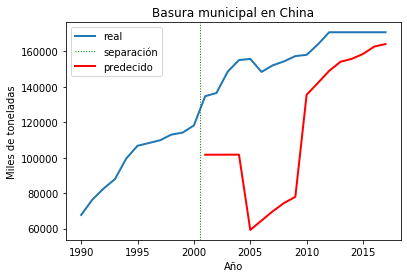

8.698675352974412


In [8]:
country = 'CHN'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en China")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
chn2000 = predictions

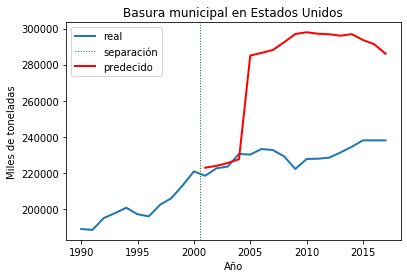

2.7534634446689346


In [9]:
country = 'USA'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en Estados Unidos")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
usa2000 = predictions

In [10]:
Year_to_separate = 2005
df = pd.read_parquet("dataset.parquet")
Y = df[['Municipal', 'Year']]
X = df[[x for x in df.columns if x not in ['Country', 'COU', 'Municipal', 'Household', 'Recovered', 'Recicled', 'Compost', 'Disposal']]]
X_train = X[X.Year < Year_to_separate].copy()
X_test = X[X.Year >= Year_to_separate].copy()
Y_train = Y[X.Year < Year_to_separate].copy()
Y_test = Y[X.Year >= Year_to_separate].copy()
#X_train = pd.read_parquet("Xtime/X_train.parquet")
#X_test = pd.read_parquet("Xtime/X_test.parquet")
#Y_train = pd.read_parquet("Ytime/Y_train.parquet")
#Y_test = pd.read_parquet("Ytime/Y_test.parquet")
X_train.drop(columns={'Year'}, inplace=True)
X_test.drop(columns={'Year'}, inplace=True)
scalerX = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train))
X_test = pd.DataFrame(scalerX.transform(X_test))
scalerY = MinMaxScaler().fit(Y_train)
Y_train = pd.DataFrame(scalerY.transform(Y_train))
Y_test = pd.DataFrame(scalerY.transform(Y_test))
Y_train = Y_train[[Y_train.columns[0]]]
Y_test = Y_test[[Y_test.columns[0]]]

In [11]:
g = GridSearch(svm.SVR(), X_train, X_test, Y_train, Y_test, parameters, verbose=True)
clf2 = svm.SVR(**g).fit(X_train, np.ravel(Y_train))

Probando: {'C': 0.5, 'epsilon': 0.1, 'kernel': 'rbf'}, 0 de 24
Tiempo de entrenamiento: 0.01224970817565918 s, score: 0.6978334430347486
Probando: {'C': 0.5, 'epsilon': 0.01, 'kernel': 'rbf'}, 1 de 24
Tiempo de entrenamiento: 0.029587268829345703 s, score: 0.7779045042846424
Probando: {'C': 0.5, 'epsilon': 0.001, 'kernel': 'rbf'}, 2 de 24
Tiempo de entrenamiento: 0.09141063690185547 s, score: 0.7860705776833876
Probando: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}, 3 de 24
Tiempo de entrenamiento: 0.007264137268066406 s, score: 0.6962438427556252
Probando: {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}, 4 de 24
Tiempo de entrenamiento: 0.06396269798278809 s, score: 0.7797260523848644
Probando: {'C': 1, 'epsilon': 0.001, 'kernel': 'rbf'}, 5 de 24
Tiempo de entrenamiento: 0.11257648468017578 s, score: 0.785919466210157
Probando: {'C': 5, 'epsilon': 0.1, 'kernel': 'rbf'}, 6 de 24
Tiempo de entrenamiento: 0.015211343765258789 s, score: 0.6942885099087235
Probando: {'C': 5, 'epsilon': 0.01, 'kern

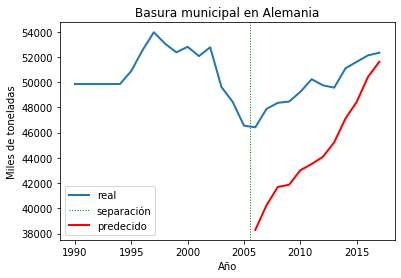

1.441695197598781


In [12]:
country = 'DEU'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en Alemania")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
deu2005 = predictions

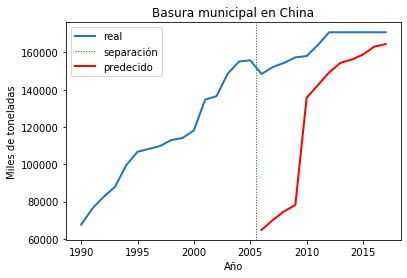

5.357164459056811


In [13]:
country = 'CHN'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en China")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
chn2005 = predictions

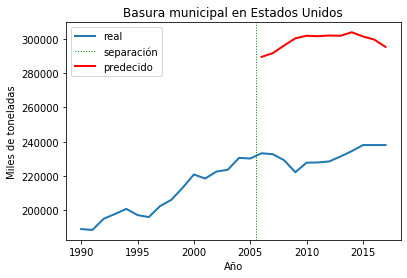

2.689997140571764


In [14]:
country = 'USA'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en Estados Unidos")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
usa2005 = predictions

In [15]:
Year_to_separate = 2010
df = pd.read_parquet("dataset.parquet")
Y = df[['Municipal', 'Year']]
X = df[[x for x in df.columns if x not in ['Country', 'COU', 'Municipal', 'Household', 'Recovered', 'Recicled', 'Compost', 'Disposal']]]
X_train = X[X.Year < Year_to_separate].copy()
X_test = X[X.Year >= Year_to_separate].copy()
Y_train = Y[X.Year < Year_to_separate].copy()
Y_test = Y[X.Year >= Year_to_separate].copy()
#X_train = pd.read_parquet("Xtime/X_train.parquet")
#X_test = pd.read_parquet("Xtime/X_test.parquet")
#Y_train = pd.read_parquet("Ytime/Y_train.parquet")
#Y_test = pd.read_parquet("Ytime/Y_test.parquet")
X_train.drop(columns={'Year'}, inplace=True)
X_test.drop(columns={'Year'}, inplace=True)
scalerX = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train))
X_test = pd.DataFrame(scalerX.transform(X_test))
scalerY = MinMaxScaler().fit(Y_train)
Y_train = pd.DataFrame(scalerY.transform(Y_train))
Y_test = pd.DataFrame(scalerY.transform(Y_test))
Y_train = Y_train[[Y_train.columns[0]]]
Y_test = Y_test[[Y_test.columns[0]]]

In [16]:
g = GridSearch(svm.SVR(), X_train, X_test, Y_train, Y_test, parameters, verbose=True)
clf3 = svm.SVR(**g).fit(X_train, np.ravel(Y_train))

Probando: {'C': 0.5, 'epsilon': 0.1, 'kernel': 'rbf'}, 0 de 24
Tiempo de entrenamiento: 0.02206254005432129 s, score: 0.8478105276580236
Probando: {'C': 0.5, 'epsilon': 0.01, 'kernel': 'rbf'}, 1 de 24
Tiempo de entrenamiento: 0.07252097129821777 s, score: 0.9472009205359431
Probando: {'C': 0.5, 'epsilon': 0.001, 'kernel': 'rbf'}, 2 de 24
Tiempo de entrenamiento: 0.1259615421295166 s, score: 0.9455948402119313
Probando: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}, 3 de 24
Tiempo de entrenamiento: 0.016894102096557617 s, score: 0.8520209950718611
Probando: {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}, 4 de 24
Tiempo de entrenamiento: 0.10311460494995117 s, score: 0.9591005503414111
Probando: {'C': 1, 'epsilon': 0.001, 'kernel': 'rbf'}, 5 de 24
Tiempo de entrenamiento: 0.11969614028930664 s, score: 0.9568993554283282
Probando: {'C': 5, 'epsilon': 0.1, 'kernel': 'rbf'}, 6 de 24
Tiempo de entrenamiento: 0.016077518463134766 s, score: 0.8615132766315219
Probando: {'C': 5, 'epsilon': 0.01, 'kerne

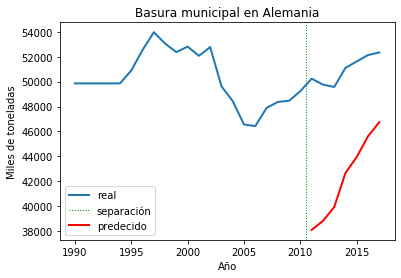

1.4779572353136


In [17]:
country = 'DEU'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en Alemania")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
deu2010 = predictions

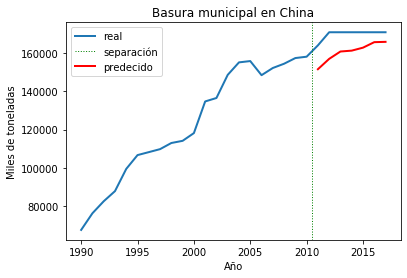

0.40357091018502783


In [18]:
country = 'CHN'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en China")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
chn2010 = predictions

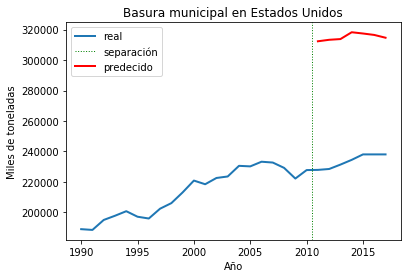

1.8088520800130645


In [19]:
country = 'USA'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en Estados Unidos")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
usa2010 = predictions

In [20]:
Year_to_separate = 2015
df = pd.read_parquet("dataset.parquet")
Y = df[['Municipal', 'Year']]
X = df[[x for x in df.columns if x not in ['Country', 'COU', 'Municipal', 'Household', 'Recovered', 'Recicled', 'Compost', 'Disposal']]]
X_train = X[X.Year < Year_to_separate].copy()
X_test = X[X.Year >= Year_to_separate].copy()
Y_train = Y[X.Year < Year_to_separate].copy()
Y_test = Y[X.Year >= Year_to_separate].copy()
#X_train = pd.read_parquet("Xtime/X_train.parquet")
#X_test = pd.read_parquet("Xtime/X_test.parquet")
#Y_train = pd.read_parquet("Ytime/Y_train.parquet")
#Y_test = pd.read_parquet("Ytime/Y_test.parquet")
X_train.drop(columns={'Year'}, inplace=True)
X_test.drop(columns={'Year'}, inplace=True)
scalerX = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scalerX.transform(X_train))
X_test = pd.DataFrame(scalerX.transform(X_test))
scalerY = MinMaxScaler().fit(Y_train)
Y_train = pd.DataFrame(scalerY.transform(Y_train))
Y_test = pd.DataFrame(scalerY.transform(Y_test))
Y_train = Y_train[[Y_train.columns[0]]]
Y_test = Y_test[[Y_test.columns[0]]]

In [21]:
g = GridSearch(svm.SVR(), X_train, X_test, Y_train, Y_test, parameters, verbose=True)
clf4 = svm.SVR(**g).fit(X_train, np.ravel(Y_train))

Probando: {'C': 0.5, 'epsilon': 0.1, 'kernel': 'rbf'}, 0 de 24
Tiempo de entrenamiento: 0.023794889450073242 s, score: 0.888158007529157
Probando: {'C': 0.5, 'epsilon': 0.01, 'kernel': 'rbf'}, 1 de 24
Tiempo de entrenamiento: 0.11030316352844238 s, score: 0.9789816770499881
Probando: {'C': 0.5, 'epsilon': 0.001, 'kernel': 'rbf'}, 2 de 24
Tiempo de entrenamiento: 0.24987173080444336 s, score: 0.9821089182009449
Probando: {'C': 1, 'epsilon': 0.1, 'kernel': 'rbf'}, 3 de 24
Tiempo de entrenamiento: 0.0285489559173584 s, score: 0.8902566542168356
Probando: {'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}, 4 de 24
Tiempo de entrenamiento: 0.14328622817993164 s, score: 0.9827200509909836
Probando: {'C': 1, 'epsilon': 0.001, 'kernel': 'rbf'}, 5 de 24
Tiempo de entrenamiento: 0.2583608627319336 s, score: 0.9841493394087539
Probando: {'C': 5, 'epsilon': 0.1, 'kernel': 'rbf'}, 6 de 24
Tiempo de entrenamiento: 0.03023219108581543 s, score: 0.8912280424037876
Probando: {'C': 5, 'epsilon': 0.01, 'kernel':

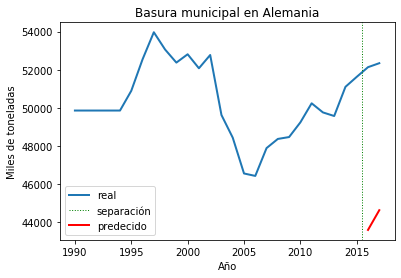

0.3687758458858642


In [22]:
country = 'DEU'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en Alemania")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
deu2015 = predictions

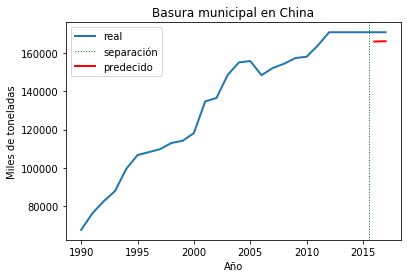

0.057525869824492135


In [23]:
country = 'CHN'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en China")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
chn2015 = predictions

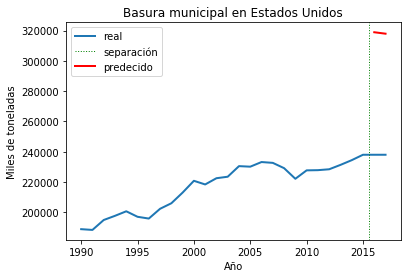

0.5047595666571995


In [24]:
country = 'USA'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
predictions = clf1.predict(pd.DataFrame(scalerX.transform(df.loc[esp.index[Year_to_separate-2017::],:][[
       'Built', 'Below Secundary', 'Income Median',
       'Population', 'Over 65', 'Over 65 Percentage', 'Over 85',
       'Over 85 Percentage', 'Over 50', 'Over 50 Percentage', 'Under 20',
       'Under 20 Percentage', 'Income Per Capita', 'Tourism', 'Area',
       'Built Area']])))
predictions = [a[0] for a in scalerY.inverse_transform([[a,0] for a in predictions])]
plt.plot(years, mun, lw=2, label='real')
plt.axvline(x=Year_to_separate + 0.5, c='green', lw=1, ls=':', label='separación')
plt.plot([y for y in years if y > Year_to_separate], predictions, c='red', lw=2, label='predecido')
plt.title("Basura municipal en Estados Unidos")
plt.xlabel("Año")
plt.ylabel("Miles de toneladas")
plt.legend()
plt.show()
print(np.abs(((np.array(mun[-len(predictions):]) - np.array(predictions)))/np.array(predictions)).sum())
usa2015 = predictions

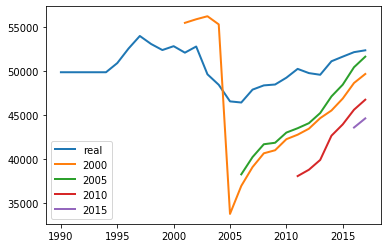

In [28]:
country = 'DEU'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
plt.plot(years, mun, lw=2, label='real')
plt.plot([y for y in years if y > 2000], deu2000, lw=2, label='2000')
plt.plot([y for y in years if y > 2005], deu2005, lw=2, label='2005')
plt.plot([y for y in years if y > 2010], deu2010, lw=2, label='2010')
plt.plot([y for y in years if y > 2015], deu2015, lw=2, label='2015')
plt.legend()

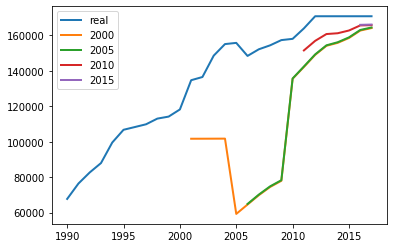

In [29]:
country = 'CHN'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
plt.plot(years, mun, lw=2, label='real')
plt.plot([y for y in years if y > 2000], chn2000, lw=2, label='2000')
plt.plot([y for y in years if y > 2005], chn2005, lw=2, label='2005')
plt.plot([y for y in years if y > 2010], chn2010, lw=2, label='2010')
plt.plot([y for y in years if y > 2015], chn2015, lw=2, label='2015')
plt.legend()

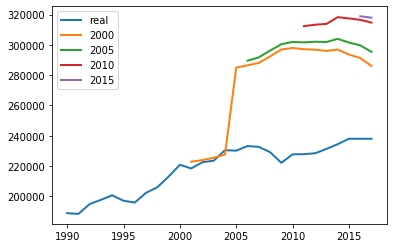

In [30]:
country = 'USA'
esp = df[df.COU == country]
years = list(esp.Year)
mun = list(esp.Municipal)
plt.plot(years, mun, lw=2, label='real')
plt.plot([y for y in years if y > 2000], usa2000, lw=2, label='2000')
plt.plot([y for y in years if y > 2005], usa2005, lw=2, label='2005')
plt.plot([y for y in years if y > 2010], usa2010, lw=2, label='2010')
plt.plot([y for y in years if y > 2015], usa2015, lw=2, label='2015')
plt.legend()